In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import img_pross_help as imgh
import tf_helper_funcs as tf_help

In [2]:
def vect_to_num(v):
    pwr = len(v)-1
    num = 0
    
    for i in range(len(v)):
        num+=v[i]*(2**pwr)
        pwr-=1
    return num
def one_hot_(v):
    ans = len(v)
    for val in v:
        if val is 1:
            return ans
        else:
            ans -=1
def extract_classnum(vect,keyref):
    outp = []
    for v in vect:
        for cat, v in keyref.items():
            outp.append(str(v) + " " + str(cat))
    return outp


In [3]:
# Dictionary for Image Encoding
key_dict = {
    'laptop':[0,0,0,1],
    'cup':[0,0,1,0],
    'chair':[0,1,0,0],
    'car':[1,0,0,0]
}
translate_dict = {
    4:'Failed Prediction Class',
    3:'Category: 1 Name: laptop',
    2:'Category: 2 Name: cup',
    1:'Category: 3 Name: chair',
    0:'Category: 4 Name: car'
}
# Data Pre-process and Global Variables
img_wh = 64 # Image Width and Height
img_flat = img_wh**2 # The size of the image flattened
img_shape = (img_wh,img_wh) # Holds the dimension of the image
color_channels = 3 # RGB is a 3 color channel
num_classes = 4 # 4 Total number of classification possibilities
#imgh.PrepImages("images/all_source_images","images/train_imgs", "images/test_imgs",img_wh,img_wh,0.7) #Only needs to be ran initially

In [4]:
train_Images,train_Labels = imgh.ImportImages("images/train_imgs",key_dict) # Extract Training Images and Labels
test_Images,test_Labels = imgh.ImportImages("images/test_imgs",key_dict)# Extract Testing Images and Labels

#train_Images = imgh.shape_up_X(train_Images,img_wh,color_channels,train_Labels.shape[0])
#test_Images = imgh.shape_up_X(test_Images,img_wh,color_channels,test_Labels.shape[0])

print("Training Label Shape: ",train_Labels.shape)
print("Training Images Shape:",train_Images.shape)
print(" ")
print("Testing Label Shape: ",test_Labels.shape)
print("Testing Images Shape:",test_Images.shape)
# Randomize Data
for i in range(10):
    r = np.random.permutation(range(len(test_Labels)))
    
    test_Labels = test_Labels[r,:]
    test_Images = test_Images[r,:]

Training Label Shape:  (227, 4)
Training Images Shape: (227, 64, 64, 3)
 
Testing Label Shape:  (96, 4)
Testing Images Shape: (96, 64, 64, 3)


In [5]:
print("Training Label Example: ")
train_Labels[0:10]

Training Label Example: 


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [6]:
X = tf.placeholder(tf.float32, shape=[None,img_wh, img_wh, color_channels]) # X Input Site
x_image = tf.reshape(X, [-1, img_wh, img_wh, color_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_classes]) # Class Output Variable

In [7]:
# Create First Convolutional Layer

CONV_L1 = tf_help.new_conv2d_layer(x_image,64,6)

# Create Second Convolutional Layer

CONV_L2= tf_help.new_conv2d_layer(CONV_L1,32,3)

# Optional Pooling Layer

#POOL_L0 = tf_help.new_max_pool(CONV_L2,4)

# Create Third Convolutional Layer with Pooling

# V1
CONV_L3= tf_help.new_conv2d_layer(CONV_L2,22,2)

# V2
#CONV_L3= tf_help.new_conv2d_layer(POOL_L0,22,2)

# Pooling Layer After Third Convolutional Layer
POOL_L1 = tf_help.new_max_pool(CONV_L3,12)

# First Fully Connected Layer 
conv3_, conv3_len = tf_help.flatten_layer(POOL_L1)
FC_L1 = tf.layers.dense(inputs= conv3_, units= conv3_len, activation = tf.nn.relu)

# Increase Accuracy with Dropout

FC_1Drop = tf.layers.dropout(FC_L1,rate=0.2,training=True)

# Second Fully Connected Layer
# V1- Without Dropout
#FC_L2 = tf.layers.dense(inputs=FC_L1, units=num_classes)
# V2- With Dropout
FC_L2 = tf.layers.dense(inputs=FC_1Drop, units=num_classes)


In [8]:
CONV_L1

<tf.Tensor 'conv2d/Relu:0' shape=(?, 64, 64, 64) dtype=float32>

In [9]:
CONV_L2

<tf.Tensor 'conv2d_2/Relu:0' shape=(?, 64, 64, 32) dtype=float32>

In [10]:
#POOL_L0
FC_1Drop

<tf.Tensor 'dropout/dropout/mul:0' shape=(?, 16038) dtype=float32>

In [11]:
CONV_L3

<tf.Tensor 'conv2d_3/Relu:0' shape=(?, 64, 64, 22) dtype=float32>

In [12]:
POOL_L1

<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 27, 27, 22) dtype=float32>

In [13]:
FC_L1

<tf.Tensor 'dense/Relu:0' shape=(?, 16038) dtype=float32>

In [14]:
FC_L2

<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 4) dtype=float32>

In [15]:
                                # Build and Connect Model
# Y
y_out =tf.nn.softmax(FC_L2) # Prototype Y output vector
#y_class = tf.argmax(y_out,axis=1) # Keep Largest Element of Vector
y_class = tf.argmax(y_out,1)

# Cost Function
cost = tf.nn.softmax_cross_entropy_with_logits(logits = FC_L2, labels = Y)
cost_fun = tf.reduce_mean(cost)

# Cost Optimization
#optimize_fun = tf.train.GradientDescentOptimizer(0.05).minimize(cost_fun)
optimize_fun = tf.train.AdamOptimizer(learning_rate=1e-5, beta1=0.9, beta2=0.999, epsilon=1e-07).minimize(cost_fun)

# Accuracy Measurements
correct_ =  tf.equal(tf.cast(y_out, tf.float32), Y)
accuracy = tf.reduce_mean(tf.cast(correct_, tf.float32))

In [16]:
# Init Session
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
# Define Batch Size for Train Step
batch_size = 8

In [17]:
                                # Training Loop
for itr in range(100):
    j_old = 0
    #print("Iteration: ",itr)
    if(itr % 10 is 0):
        r = np.random.permutation(range(int(len(test_Labels)/3)))
        accr = accuracy.eval(feed_dict = {X:test_Images[r], Y:test_Labels[r]})
        print(" At Iteration: " + str(itr) + " Accuracy: "+'{:.2%}'.format(accr))
    if(itr % 25 is 0):
        print("Randomizing..")
        r = np.random.permutation(range(len(train_Labels)))
        train_Labels = train_Labels[r,:]
        train_Images = train_Images[r,:]
    # Loop to Batch Train
    for j in range(batch_size,len(train_Images),batch_size):
        session.run(optimize_fun,feed_dict = {X:train_Images[j_old:j], Y:train_Labels[j_old:j]})
        j_old = j

 At Iteration: 0 Accuracy: 4.69%
Randomizing..
 At Iteration: 10 Accuracy: 46.88%
 At Iteration: 20 Accuracy: 64.84%
Randomizing..
 At Iteration: 30 Accuracy: 72.66%
 At Iteration: 40 Accuracy: 70.31%
 At Iteration: 50 Accuracy: 73.44%
Randomizing..
 At Iteration: 60 Accuracy: 56.25%
 At Iteration: 70 Accuracy: 76.56%
Randomizing..
 At Iteration: 80 Accuracy: 75.78%
 At Iteration: 90 Accuracy: 82.03%


In [18]:
p = accuracy.eval(feed_dict = {X:test_Images[0:50], Y:test_Labels[0:50]})
p2 = accuracy.eval(feed_dict = {X:test_Images[50:100], Y:test_Labels[50:100]})
test = session.run(y_class,feed_dict = {X:test_Images[0:50], Y:test_Labels[0:50]})
print("Accuracy: ")
avg = (p+p2)/2
print( '{:.2%}'.format(avg))
print()
print("Results: ")
#test = np.argmax(test) 
print(test)
print()
print("True Labels: ")
print(np.argmax(test_Labels[0]))
#print("One Hot Val: ", np.argmax(test_Labels[0]))
for i in range(0,50):
    print("At Index: %d"%(i))
    print("Predicted: %s --> Actual: %s"%(translate_dict[(test[i])],translate_dict[np.argmax(test_Labels[i])]))

Accuracy: 
76.40%

Results: 
[3 2 2 3 2 2 3 0 3 3 0 0 3 3 3 0 0 0 2 0 0 3 0 0 1 2 0 0 3 1 0 0 3 2 3 3 2
 3 0 1 0 1 2 0 1 0 0 1 3 1]

True Labels: 
3
At Index: 0
Predicted: Category: 1 Name: laptop --> Actual: Category: 1 Name: laptop
At Index: 1
Predicted: Category: 2 Name: cup --> Actual: Category: 2 Name: cup
At Index: 2
Predicted: Category: 2 Name: cup --> Actual: Category: 2 Name: cup
At Index: 3
Predicted: Category: 1 Name: laptop --> Actual: Category: 1 Name: laptop
At Index: 4
Predicted: Category: 2 Name: cup --> Actual: Category: 3 Name: chair
At Index: 5
Predicted: Category: 2 Name: cup --> Actual: Category: 1 Name: laptop
At Index: 6
Predicted: Category: 1 Name: laptop --> Actual: Category: 2 Name: cup
At Index: 7
Predicted: Category: 4 Name: car --> Actual: Category: 4 Name: car
At Index: 8
Predicted: Category: 1 Name: laptop --> Actual: Category: 1 Name: laptop
At Index: 9
Predicted: Category: 1 Name: laptop --> Actual: Category: 1 Name: laptop
At Index: 10
Predicted: Categ

Category: 1 Name: laptop


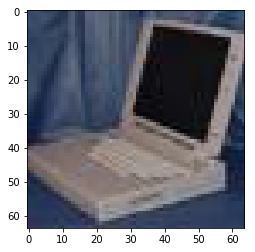

In [19]:
ref_index = 9
img = test_Images[ref_index]

plt.imshow(img.astype(np.uint8))
print(translate_dict[(test[ref_index])])